# Pipeline for Ca-Data-Preprocessing and Analysis

# Calcium Imaging preprocessing
---
* Author: Yue Zhang and David Burkhardt (AG Arrenberg)
* date: 17/04/2023

In [1]:
# import libraries
from skimage import io
import os
import numpy as np
from PyQt5.QtWidgets import QFileDialog, QApplication

from Exp4_for_test_data import * # use Exp4_for_test_data for running test data
# from Exp4 import # use Exp4 for running your own data

# %matplotlib notebook
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
working_dir = "C:\\Users\\dburkhardt\\Desktop\\preprocessing_arrenberg_practical_2022-main\\preprocessing_arrenberg_practical_2022_test\\test_data\\"
ca_filename = "rec6_Speed_ng20um_20220704_laser19_gain_620_mag2_jf7_5dpf_2fps.TIF"
timeline_filename = "Io.hdf5"
stimulus_filename = "Display.hdf5"

In [3]:
# load calcium data
ca_movie = load_ca_movie(working_dir+ca_filename)

## Registration

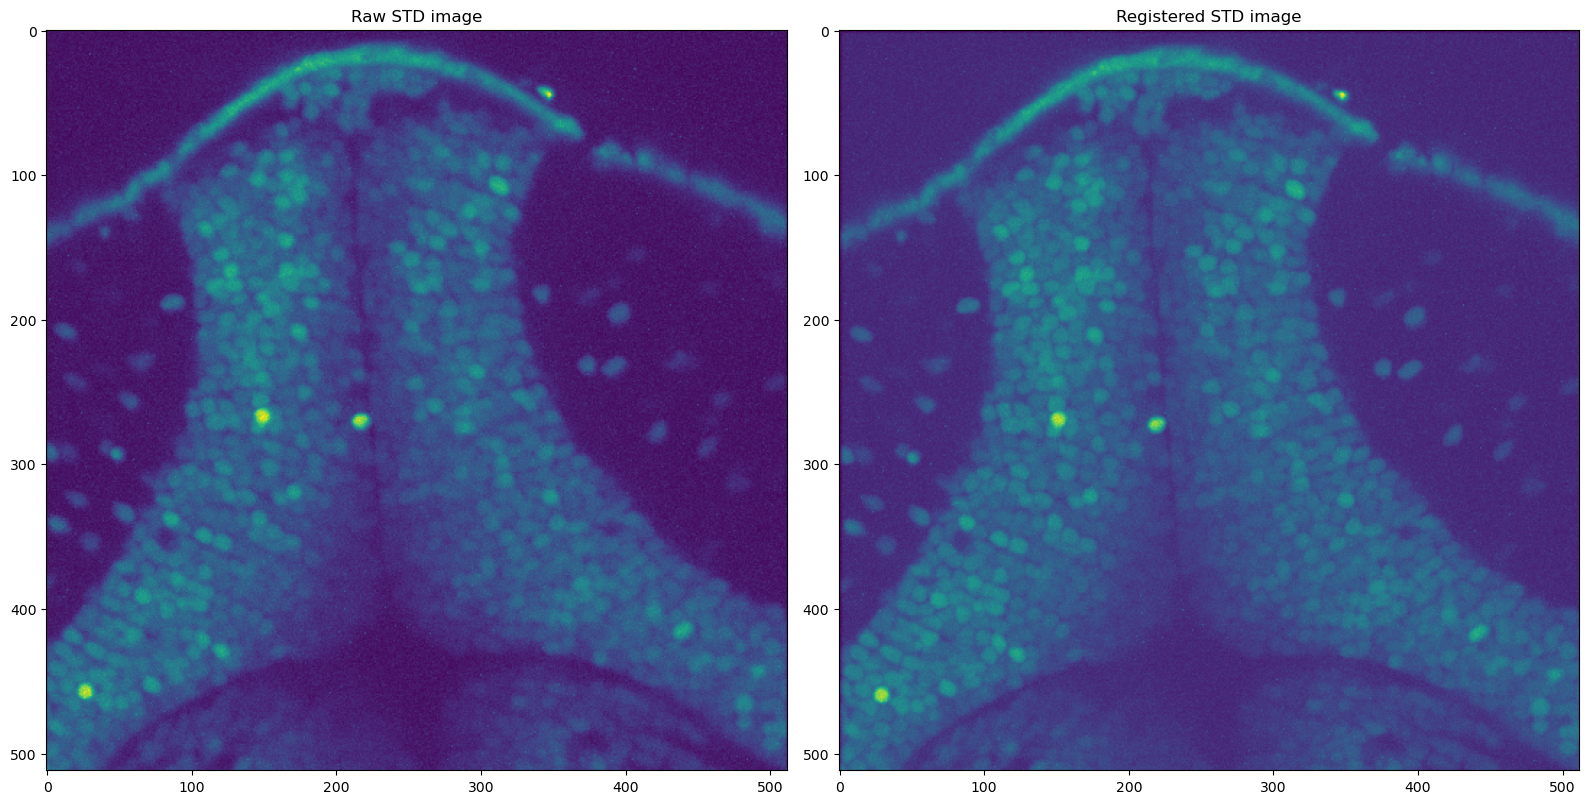

In [4]:
# registration (motion correction) of calcium frames and computation of STD image
reg_frames, std_image = motion_correction(ca_movie, binsize=60, stepsize=40)    #10, 10

## Cell Segmentation

C:\Users\dburkhardt\Desktop\preprocessing_arrenberg_practical_2022-main\preprocessing_arrenberg_practical_2022_test\Exp4_for_test_data.py:162: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  maxCoord = peak_local_max(smoothed_std_image, footprint=conn, indices=False, exclude_border=0)


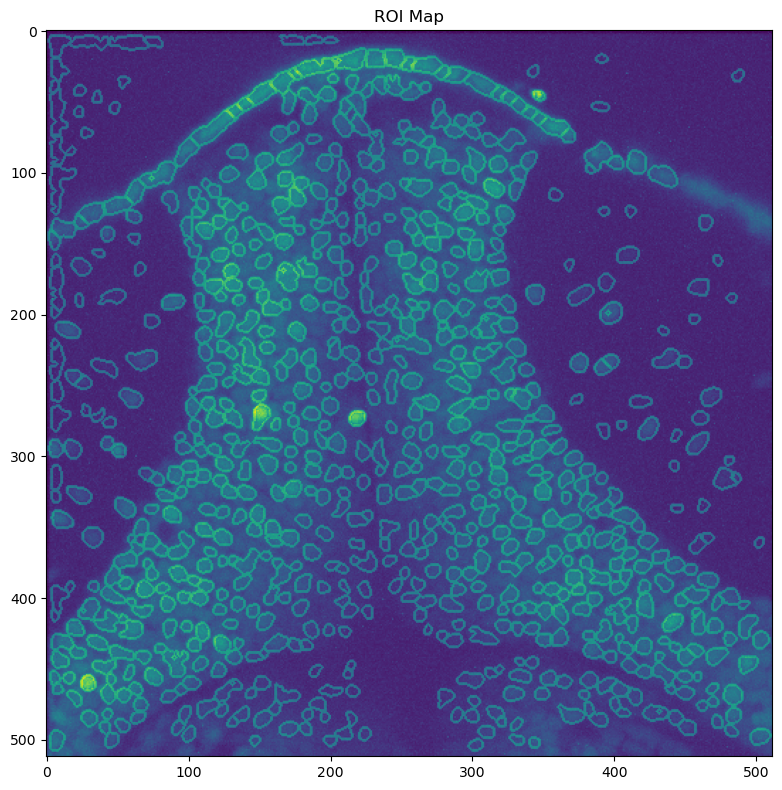

In [5]:
# cell (ROIs) segmentation with watershed algorithm
segmentation_params = {
    'hpfiltSig': .1,
    'localThreKerSize': 9,
    'smoothSig': 3,
    'binaryThre': .5,
    'minSizeLim': 20,
    'maxSizeLim': 500,
    'bgKerSize': 2,
    'fgKerSize': 1
    }
roi_mask = cell_segmentation(std_image, segmentation_params)

In [6]:
# extract calcium traces for ROIs
raw_ca_traces = extract_calcium_signals(roi_mask, reg_frames, display_traces=False)

# size of array
print(np.array(raw_ca_traces).shape)

(780, 1059)


## DF/F Computation
compute DF/f for each calcium trace
* Hint: $\frac{\Delta F}{F} = \frac{F(t) - F_{0}}{F_{0}}$

In [8]:
dff_ca_traces = None # put your calculation here

## Stimulus Parameter Aquisition

Text(0.5, 0, '#frames')

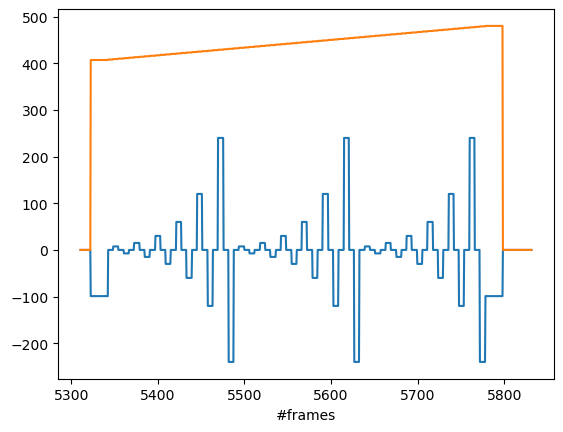

In [9]:
# acquire stimulus parameter for each calcium frames
stim_array = align_stimulus_to_ca_frames(timefn=working_dir+timeline_filename,stim_fn=working_dir+stimulus_filename)

# visualize
plt.figure()
plt.plot(stim_array['time'],stim_array['speed'])
plt.plot(stim_array['time'],stim_array['phase'])
plt.xlabel('#frames')
# plt.plot(stim_array['time'],stim_array['spatial_freq'])

In [10]:
# store ROIs and stimulus parameters  in one DataFrame
roi_id = np.unique(roi_mask)[1:]
formatted = pd.DataFrame(np.array(dff_ca_traces).T,columns=roi_id)
for k,v in stim_array.items():
    formatted["stim_"+k] = v
    
# visualize
formatted

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,stim_phase,stim_speed,stim_spatial_freq,stim_time
0,125371,151398,180533,71744,46964,35057,56090,427659,32623,633679,418754,117850,172016,467645,668180,31248,141989,150436,285061,39509,40434,301486,39729,159821,159692,511914,75618,41555,167438,33488,524242,161805,97454,222985,169041,150821,174515,361516,28812,127325,...,94990,56058,90378,158093,69151,181525,196861,90124,44822,45590,98061,106223,50231,98480,53433,85545,66814,77413,67551,63678,82121,123929,154597,85896,83468,50136,108565,73409,179992,114648,237196,48022,81000,56726,79654,66718,0.0,0.0,0.0,5310.754694
1,130908,138528,188664,73092,51417,22796,54203,495210,30092,748867,341827,121628,170803,485413,727932,42644,98223,154635,309679,56762,61308,391703,30926,136289,199648,483840,75009,42963,192376,27116,482080,144931,83657,197375,139393,187769,152805,253209,24713,180626,...,84840,60158,75587,209854,92972,165488,237425,102322,29903,48886,95341,119124,43062,119480,48824,74369,60218,102158,61151,78788,86536,112242,149317,72452,94509,65758,88331,72100,202463,100625,237072,31822,73377,66686,45684,76932,0.0,0.0,0.0,5311.259023
2,130623,155368,173490,66783,45910,26059,51062,481255,34030,666008,324051,104818,159049,529883,604955,32973,149095,156939,301101,33840,52664,499760,28524,163152,191447,412126,63292,37233,201535,41748,500716,101328,94928,160811,153670,152549,194777,249912,30350,164941,...,86890,46999,62108,169935,62139,208386,219844,102704,35505,56445,65949,142689,46869,102033,47639,62300,77446,83722,86600,81192,80550,111671,137699,85413,92458,64061,105681,82537,165840,97970,284422,52953,49843,49720,73025,59610,0.0,0.0,0.0,5311.742843
3,123004,142240,167504,72996,57242,30895,69377,400480,43733,600670,392698,101297,170350,501387,729110,33839,114840,122615,306738,36145,54330,331069,45272,183541,188405,433704,61564,49495,190585,26793,448213,151141,93420,162891,141251,165452,173139,365391,33518,155496,...,66751,58076,73413,155273,71039,189271,145282,96812,37522,48631,95115,126682,26412,84905,33741,62396,67518,90347,75461,52404,63580,103408,138178,90060,99696,77477,90859,70785,154919,127963,289732,42229,59711,50074,67136,61372,0.0,0.0,0.0,5312.217322
4,125238,145858,179315,71170,60861,20906,52409,362350,31119,557443,402174,110163,133692,368014,616998,41781,179251,118554,280001,59481,50648,326494,27979,160363,200125,509555,45015,46070,211560,27759,481727,139902,116695,254073,131228,164813,185077,315349,31437,210403,...,82728,75874,63740,226825,66756,187897,215815,93486,37489,38127,94154,144228,42548,81768,47573,97711,80711,89101,109138,80553,61884,112723,113012,72194,108785,77058,68801,81190,185624,127515,303983,30510,64957,37073,32719,64029,0.0,0.0,0.0,5312.734308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,133406,169484,175122,73956,47350,27949,48629,311729,26670,635177,306543,97903,151368,434541,642770,34386,134590,162605,229294,41559,43383,425000,33522,108529,193722,409728,43060,42774,246390,33742,494436,167117,117463,182740,123351,147654,119127,53817,34130,135260,...,78279,50551,53657,178964,71678,209119,196924,84775,27950,60991,81063,124379,32943,106195,33743,77155,73025,85574,89034,52310,65759,99889,104690,80934,70817,46294,82022,78309,133377,113683,224430,73282,95757,47125,58329,72385,0.0,0.0,0.0,5828.833969
1055,128445,148549,172844,90187,44918,20071,64253,307438,29647,634667,346499,96909,164044,478337,783573,34768,122265,149958,274817,44403,61148,420074,32785,135456,201440,470749,74786,48022,199128,32849,563085,215307,72741,1514

Text(0, 0.5, '#ROIs')

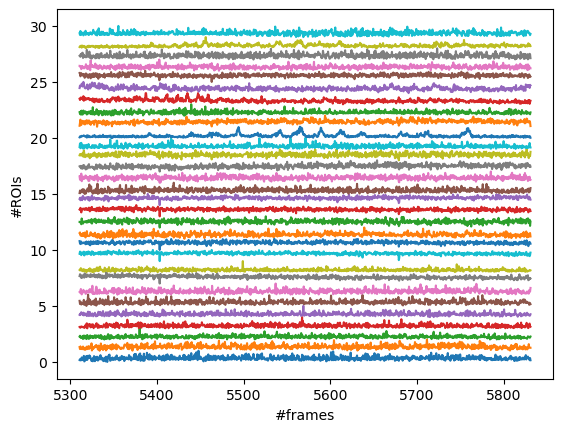

In [11]:
# plot some example calcium traces
plt.figure()
for i in range(30):
    plt.plot(formatted['stim_time'],rnorm(formatted[i+1].to_numpy())+i)
plt.xlabel('#frames')
plt.ylabel('#ROIs')

## ROI Analysis

Text(0.5, 0, 'Frame #')

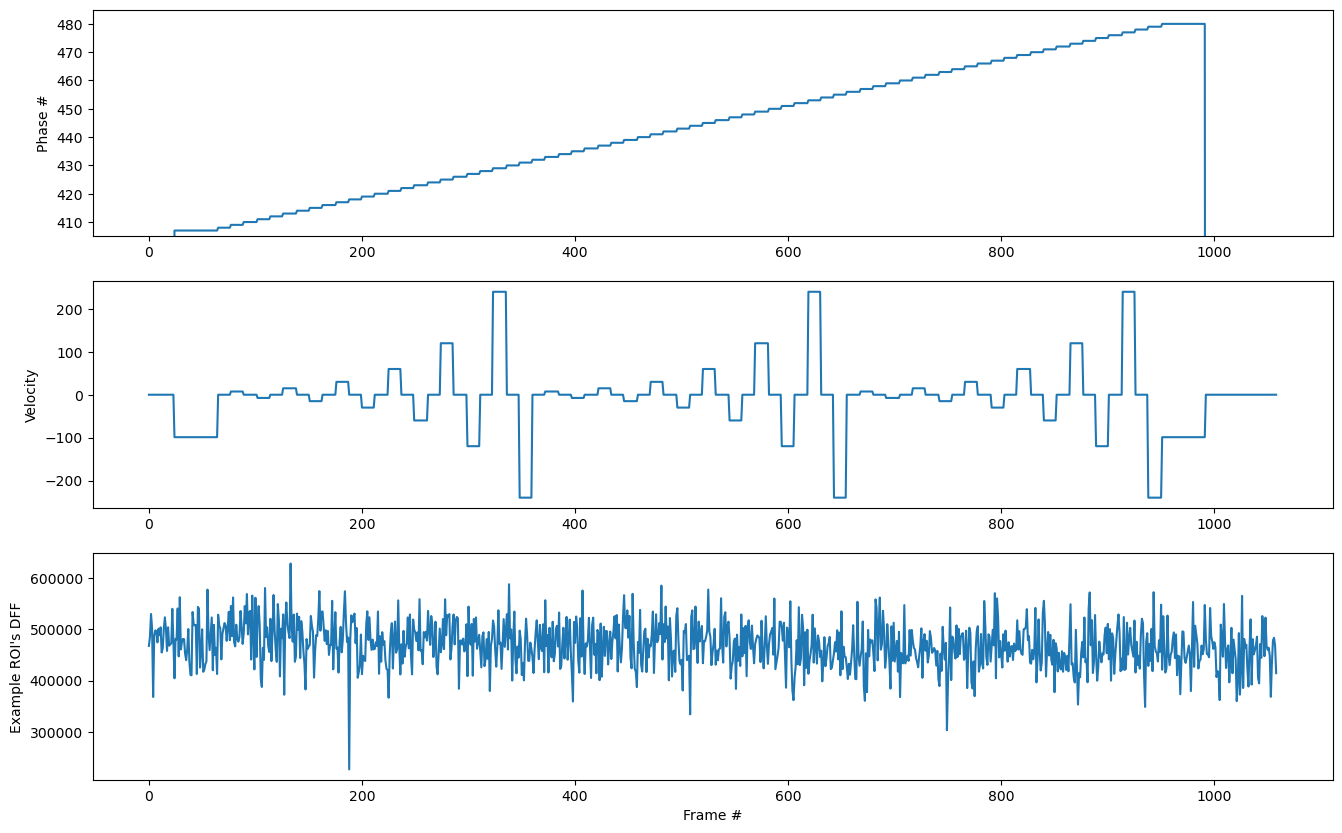

In [12]:
# visualization of stimulus phase, velocity and a example ROI
fig, axes = plt.subplots(3, 1, figsize=(16, 10))
axes[0].plot(formatted['stim_phase'])
axes[0].set_ylim(405, 485)
axes[0].set_ylabel('Phase #')

axes[1].plot(formatted['stim_speed'])
axes[1].set_ylabel('Velocity')

axes[2].plot(formatted[14])
axes[2].set_ylabel('Example ROI\'s DFF')

axes[2].set_xlabel('Frame #')

### Calculate mean DFF for stimulation phase

In [13]:
# put your calculation here

### Calculate auto-correlation between stimulus repeats

In [14]:
# put your calculation here

### Calculate correlation between mean phase-DFF and stimulus regressors

Text(0.5, 0, 'Frame #')

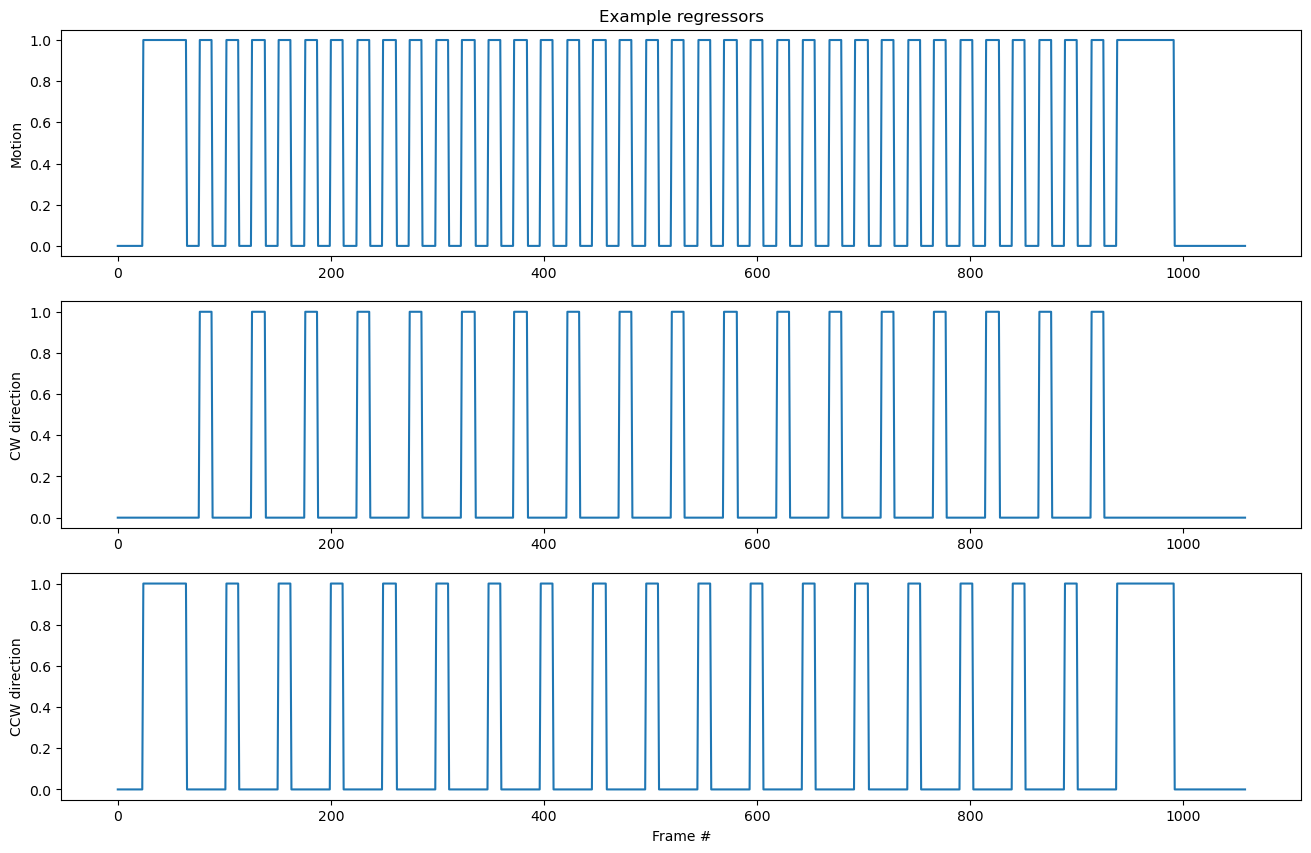

In [15]:
# example plots for different regressors 
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

axes[0].set_title('Example regressors')

axes[0].plot(formatted['stim_speed'] != 0)
axes[0].set_ylabel('Motion')

axes[1].plot(formatted['stim_speed'] > 0)
axes[1].set_ylabel('CW direction')

axes[2].plot(formatted['stim_speed'] < 0)
axes[2].set_ylabel('CCW direction')

axes[2].set_xlabel('Frame #')

In [16]:
# put your calculation here